# Wikispeedia

### Setup

In [1]:
import pandas as pd
import networkx as nx
import nx_parallel as nxp
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import os
import json

from joblib import parallel_config, Parallel, delayed

Enable networkx's config for nx-parallel and set global configs

In [3]:
nx.config.backends.parallel.active = True

nxp_config = nx.config.backends.parallel
nxp_config.n_jobs = -1

### Load data, preprocessing

Read graph data

In [8]:
links = pd.read_csv('wikispeedia_paths-and-graph/links.tsv', delimiter='\t', names=['linkSource', 'linkTarget'], header=None, comment="#")
articles = pd.read_csv('wikispeedia_paths-and-graph/articles.tsv', delimiter='\t', names=['article'], header=None, comment="#")

Read game data

In [11]:
paths_finished = pd.read_csv('wikispeedia_paths-and-graph/paths_finished.tsv', delimiter='\t', usecols=[3], names=['path'], header=None, comment="#")
paths_finished['target'] = paths_finished['path'].apply(lambda x: x.split(';')[-1])
paths_finished['path'] = paths_finished['path'].apply(lambda x: x.split(';'))

paths_unfinished = pd.read_csv('wikispeedia_paths-and-graph/paths_unfinished.tsv', delimiter='\t', usecols=[3, 4], names=['path', 'target'], header=None, comment="#")
paths_unfinished['path'] = paths_unfinished['path'].apply(lambda x: x.split(';'))

paths = pd.concat([paths_finished, paths_unfinished], ignore_index=True)

Filter game data to discard '<'

In [14]:
filtered_paths = [] 
    
for p in paths['path']:
    indices  = [index for (index, item) in enumerate(p) if item == '<']
    filter_indices = []; 
    for index in indices: filter_indices.extend([index - 1, index])
    filtered_paths.append([item for index, item in enumerate(p) if index not in filter_indices])

Generate the graph

In [17]:
G = nx.from_pandas_edgelist(links, source='linkSource', target='linkTarget', create_using=nx.DiGraph)
disconnected_nodes = set(articles['article'].tolist()) - set(G.nodes)
G.add_nodes_from(disconnected_nodes)

H = nxp.ParallelGraph(G)

### Central article usage by players

Compute the shortest-path betweenness centrality for nodes (not approximated)

In [21]:
nodes_bc = nxp.betweenness_centrality(H);

Article usage by players

In [23]:
sorted_bc = sorted(nodes_bc.items(), key=lambda item: item[1], reverse=True)
percentage_bc = []
percentage_l = []
for i in range(1, 100):
    percentage_bc.append(sorted_bc[i][1])
    percentage_l.append(sorted_bc[i][0])

percentage_finished = []
for i in range(1, 100):
    count = 0
    for path in paths_finished['path']:
        if sorted_bc[i][0] in path:
            count += 1
    percentage_finished.append(count/len(paths_finished['path']))
print()

percentage_unfinished = []
for i in range(1, 100):
    count = 0
    for path in paths_unfinished['path'][1:-1]:
        if sorted_bc[i][0] in path:
            count += 1
    percentage_unfinished.append(count/len(paths_unfinished['path']))

Plot

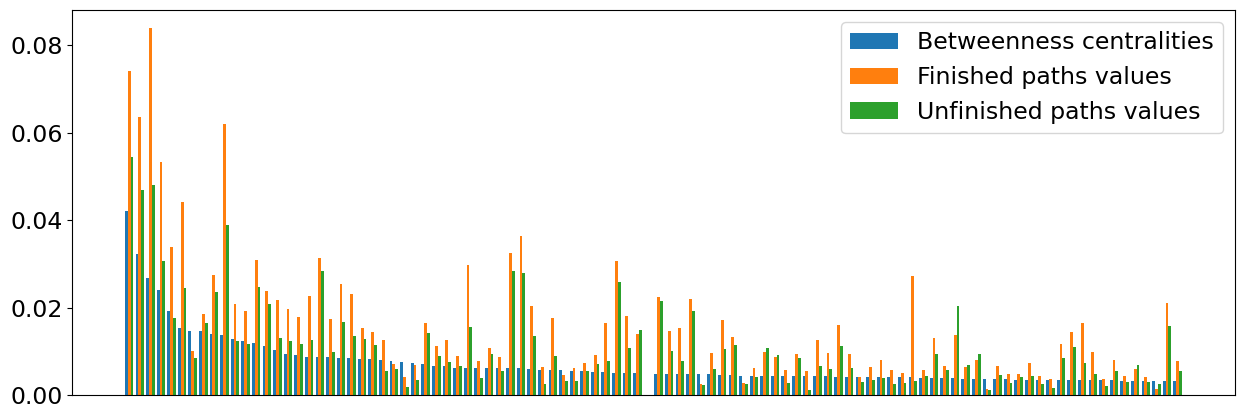

In [32]:
SMALL_SIZE = 17
MEDIUM_SIZE = 17
BIGGER_SIZE = 17

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

_ = plt.figure(figsize=(15, 5))
_ = plt.hist(
    [percentage_l, percentage_l, percentage_l],
    weights=[percentage_bc, percentage_finished, percentage_unfinished],
    align='left',
    label=['Betweenness centralities', 'Finished paths values', 'Unfinished paths values'],
    bins=100,
)
_ = plt.xticks([])
_ = plt.legend()

_ = plt.savefig('BetweennessHist.pdf')

### Player paths analysis

_Runs in $\approx$1m_

In [42]:
unique_couples = []

for index, row in paths.iterrows():
    src = row['path'][0]
    dst = row['target']
    if(not [src, dst] in unique_couples):
        unique_couples.append([src, dst])

Compute all shortest paths 

In [ ]:
def shortest_paths_f(couple):
    try:
        shortest_paths_generator = nx.all_shortest_paths(G, couple[0], couple[1])
        shortest_paths = list(shortest_paths_generator)
        if not os.path.isdir('shortest_paths'):
            os.makedirs('shortest_paths')
        with open('shortest_paths/' + couple[0] + '#' + couple[1] + '.py', 'w') as out_file:
            out_file.write(json.dumps(shortest_paths))
    except Exception as e:
        print(couple[0] + '#' + couple[1] + ' exception : ' + str(e))

_Run to compute the shortest paths, runs in $\approx$1.5h_

_Just computed!_

In [ ]:
Parallel(n_jobs=-1)(delayed(shortest_paths_f)(couple) for couple in unique_couples)

Compute the metrics

In [50]:
def compare_paths(player_path, optimal_paths, output_folder):
   
    best_beg_equal_nodes = 0
    best_end_equal_nodes = 0
    best_total_equal_nodes = 0
        
    for op in optimal_paths:

        i = 0
        while(i < len(op) and i < len(player_path) and player_path[i] == op[i]): i = i + 1
        beg_equal_nodes = i
            
        i = 0
        while(i > -len(op) and i > -len(player_path) and player_path[i - 1] == op[i - 1]): i = i - 1
        end_equal_nodes = -i

        total_equal_nodes = len(list(set(op).intersection(player_path)))

        if beg_equal_nodes > best_beg_equal_nodes: best_beg_equal_nodes = beg_equal_nodes
        if end_equal_nodes > best_end_equal_nodes: best_end_equal_nodes = end_equal_nodes
        if total_equal_nodes > best_total_equal_nodes: best_total_equal_nodes = total_equal_nodes

    try:
        if not os.path.isdir(output_folder):
            os.makedirs(output_folder)
        with open(output_folder + '/' + optimal_paths[0][0] + '#' + optimal_paths[0][-1] + '.txt', 'a') as out_file:
            out_file.write(
                str(len(optimal_paths[0])) + ' ' + 
                str(len(player_path)) + ' ' +
                str(best_beg_equal_nodes) + ' ' + 
                str(best_end_equal_nodes) + ' ' + 
                str(best_total_equal_nodes) + ' ' +
                str(int(player_path[-1] == optimal_paths[0][-1])) + '\n'
            )
            
    except Exception as e:
        print(optimal_paths[0][0] + '#' + optimal_paths[0][-1] + ' exception : ' + str(e))

_Run to compute the metrics, runs in $\approx$5m_

_Just computed!_

In [54]:
for index, row in paths.iterrows():
    optimal_paths = []
    try:
        with open('shortest_paths' + '/' + row['path'][0] + '#' + row['target'] + '.py') as in_file:
            optimal_paths = json.load(in_file)
        compare_paths(row['path'], optimal_paths, 'metrics')
    except Exception as e:
        print(row['path'][0] + '#' + row['target'] + ' exception : ' + str(e))

Bird#Wikipedia_Text_of_the_GNU_Free_Documentation_License exception : [Errno 2] No such file or directory: 'shortest_paths/Bird#Wikipedia_Text_of_the_GNU_Free_Documentation_License.py'
Black_pepper#Long_peper exception : [Errno 2] No such file or directory: 'shortest_paths/Black_pepper#Long_peper.py'
Star_Trek#Test exception : [Errno 2] No such file or directory: 'shortest_paths/Star_Trek#Test.py'
World_War_II#Adolph_Hitler exception : [Errno 2] No such file or directory: 'shortest_paths/World_War_II#Adolph_Hitler.py'
Marco_Polo#Netbook exception : [Errno 2] No such file or directory: 'shortest_paths/Marco_Polo#Netbook.py'
Oasis_%28band%29#Final_Fantasy_%28video_game%29 exception : [Errno 2] No such file or directory: 'shortest_paths/Oasis_%28band%29#Final_Fantasy_%28video_game%29.py'
Watercolor_painting#Podcast exception : [Errno 2] No such file or directory: 'shortest_paths/Watercolor_painting#Podcast.py'
Andrew_Jackson#Christmas exception : [Errno 2] No such file or directory: 'shor

Metrics distributions (_runs in $\approx$2m_)

In [61]:
data = []

for couple in unique_couples:
    try:
        with open('metrics' + '/' + couple[0] + '#' + couple[1] + '.txt') as in_file:
            file_lines = in_file.readlines()
            for line in file_lines:
                s = line.split() 
                v = int(s[0]) - 1  # len
                w = int(s[1]) - 1  # player len
                d = int(s[1]) - int(s[0]) # difference
                x = max(int(s[2]) - 1, 0)  # beg equal edges 
                y = max(int(s[3]) - 1, 0)  # end equal edges
                z = max(int(s[4]) - 1, 0)  # total equal edges
                t = bool(int(s[5])) # finished?
                data.append([v, w, d, x, y, z, t])
    except Exception as e:
        print(couple[0] + '#' + couple[1] + ' exception : ' + str(e))
df = pd.DataFrame(data, columns = ['Optimal length', 'Player length', 'Difference', 'Beg equal edges', 'End equal edges', 'Tot equal edges', 'Finished']) 

Bird#Wikipedia_Text_of_the_GNU_Free_Documentation_License exception : [Errno 2] No such file or directory: 'metrics/Bird#Wikipedia_Text_of_the_GNU_Free_Documentation_License.txt'
Black_pepper#Long_peper exception : [Errno 2] No such file or directory: 'metrics/Black_pepper#Long_peper.txt'
Star_Trek#Test exception : [Errno 2] No such file or directory: 'metrics/Star_Trek#Test.txt'
World_War_II#Adolph_Hitler exception : [Errno 2] No such file or directory: 'metrics/World_War_II#Adolph_Hitler.txt'
Marco_Polo#Netbook exception : [Errno 2] No such file or directory: 'metrics/Marco_Polo#Netbook.txt'
Oasis_%28band%29#Final_Fantasy_%28video_game%29 exception : [Errno 2] No such file or directory: 'metrics/Oasis_%28band%29#Final_Fantasy_%28video_game%29.txt'
Watercolor_painting#Podcast exception : [Errno 2] No such file or directory: 'metrics/Watercolor_painting#Podcast.txt'
Andrew_Jackson#Christmas exception : [Errno 2] No such file or directory: 'metrics/Andrew_Jackson#Christmas.txt'
Music#Sp

Plot

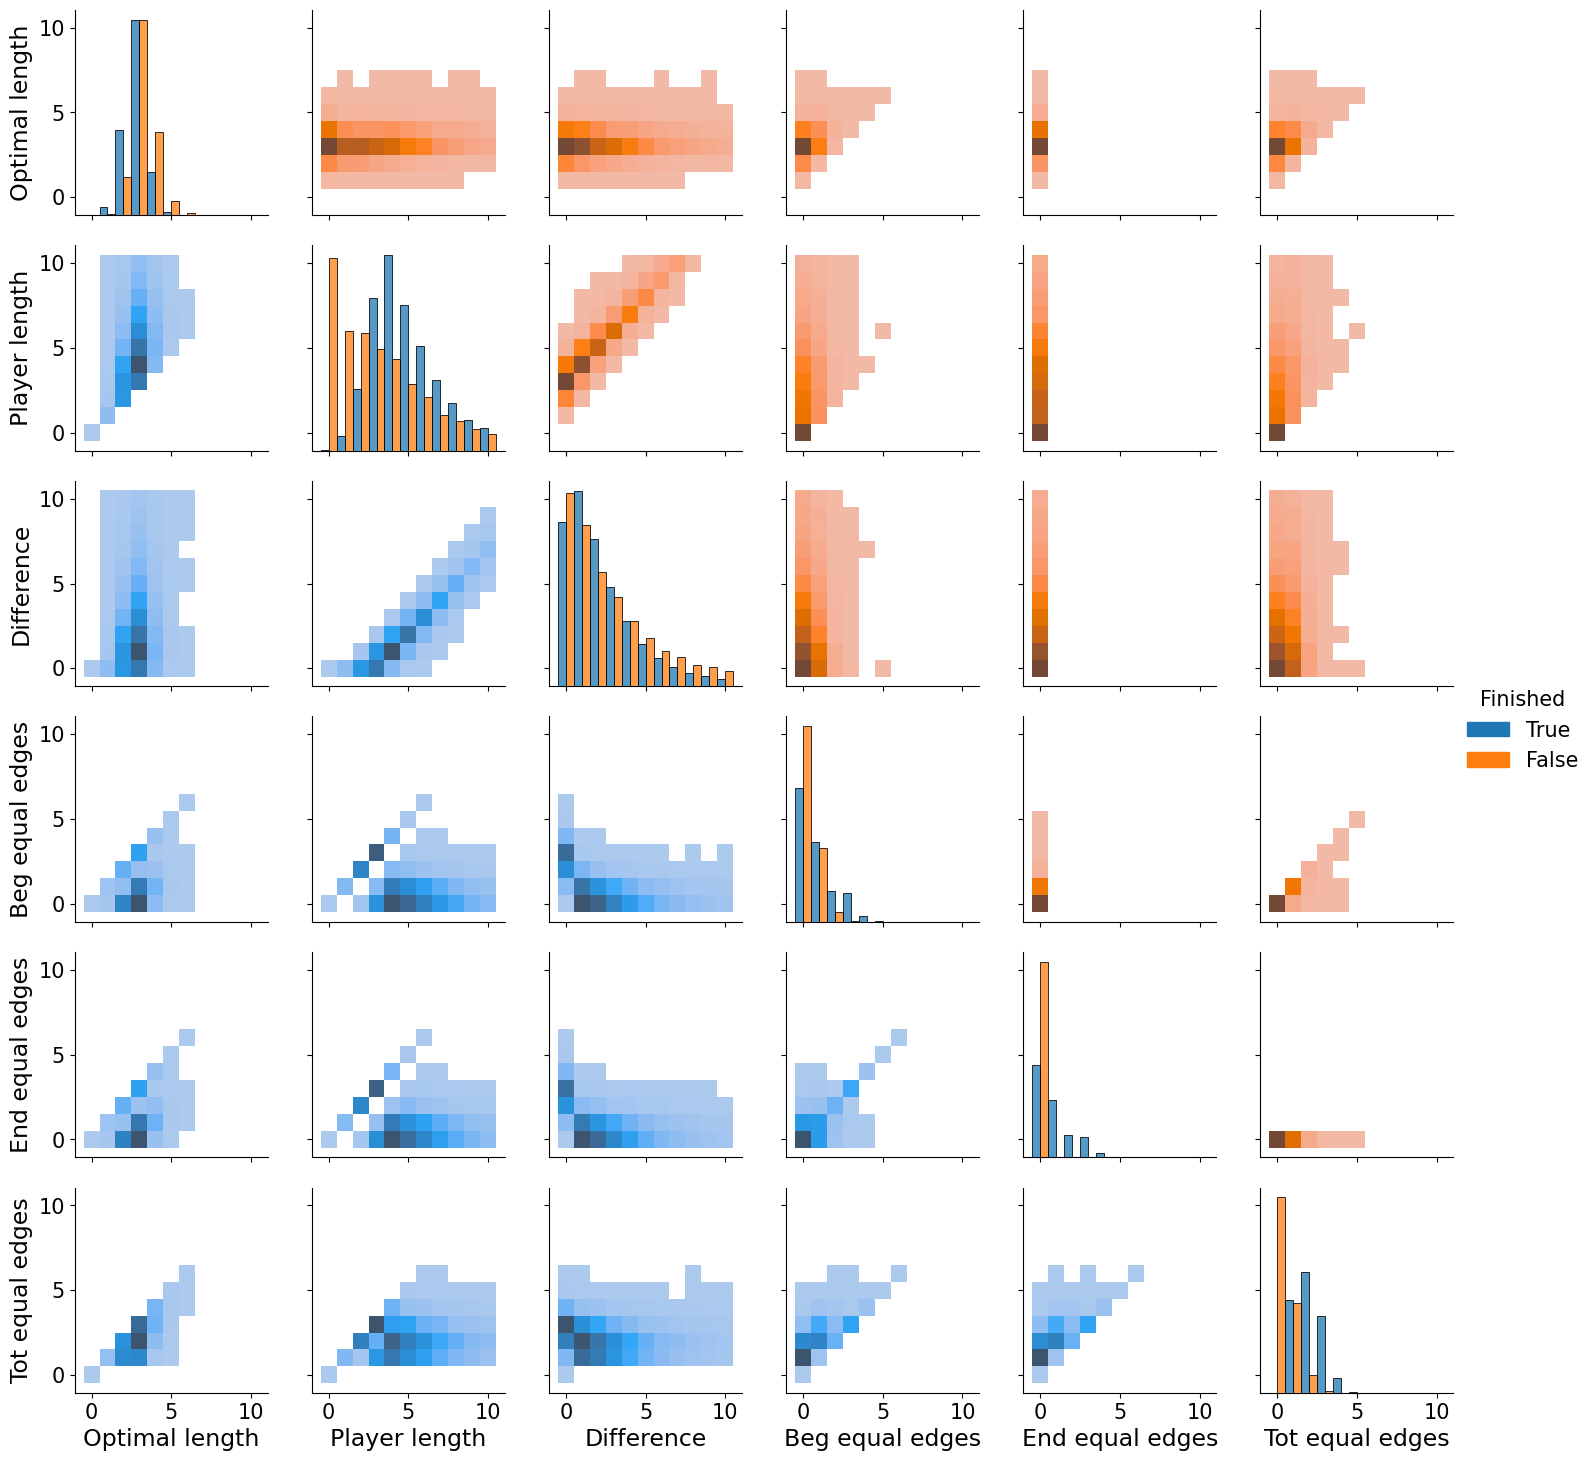

In [70]:
SMALL_SIZE = 15
MEDIUM_SIZE = 17
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

g = sns.PairGrid(df, hue='Finished', hue_order=[True, False], diag_sharey=False)
g.map_diag(sns.histplot, binwidth=1, binrange=(0, 10), multiple='dodge', stat='density', common_norm=False, discrete=True)
g.data = df[df['Finished'] == True]
g.map_lower(sns.histplot, binwidth=1, binrange=(0, 10), discrete=True, stat='density')
g.data = df[df['Finished'] == False]
g.map_upper(sns.histplot, binwidth=1, binrange=(0, 10), discrete=True, stat='density')
g.add_legend()

_ = plt.savefig('ComparisonHue.pdf')

### Shortest paths lengths distribution

Wikispeedia lengths histogram

In [74]:
lengths_dict_G = dict(nx.all_pairs_shortest_path_length(G))
lengths_list_G = []
for src in G.nodes:
        for dst in G.nodes:
            try:
                lengths_list_G.append(lengths_dict_G[src][dst])
            except Exception as e:
                continue

max_len = 10
hist_G = np.histogram(lengths_list_G, bins=range(max_len + 2), density=True)[0]

Random graphs histogram

In [77]:
lengths_list = []
mc_samples = 50

_Run to generate the graphs and evaluate the distances between all the articles_

_Just computed!_

In [ ]:
for i in range(mc_samples):
    print(i)
    GG = nx.directed_configuration_model([G.in_degree(node) for node in G], [G.out_degree(node) for node in G])
    lengths_dict = dict(nx.all_pairs_shortest_path_length(GG))
    sample_lengths = []
    for src in GG.nodes:
        for dst in GG.nodes:
            try:
                sample_lengths.append(lengths_dict[src][dst])
            except Exception as e:
                continue
    lengths_list.append(sample_lengths)

_Load the distances_ 

_File not uploaded on GitHub, it was too large, $\approx$3GB_

In [86]:
with open('random_graphs_distances.py') as in_file:
    lengths_list = json.load(in_file)

In [89]:
hists = []

for l in lengths_list:
    hists.append(np.histogram(l, bins=range(max_len + 2), density=True)[0])

hists = np.array(hists)

In [91]:
hists_mean = np.mean(hists, axis=0)
hists_stds = np.std(hists, axis=0, ddof=1)

In [93]:
z_scores = []
for i in range(max_len + 1):
    z_scores.append((hist_G[i] - hists_mean[i])/hists_stds[i])

C:\Users\rdv01\AppData\Local\Temp\ipykernel_4408\1727826892.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  z_scores.append((hist_G[i] - hists_mean[i])/hists_stds[i])
C:\Users\rdv01\AppData\Local\Temp\ipykernel_4408\1727826892.py:3: RuntimeWarning: invalid value encountered in scalar divide
  z_scores.append((hist_G[i] - hists_mean[i])/hists_stds[i])


Plot

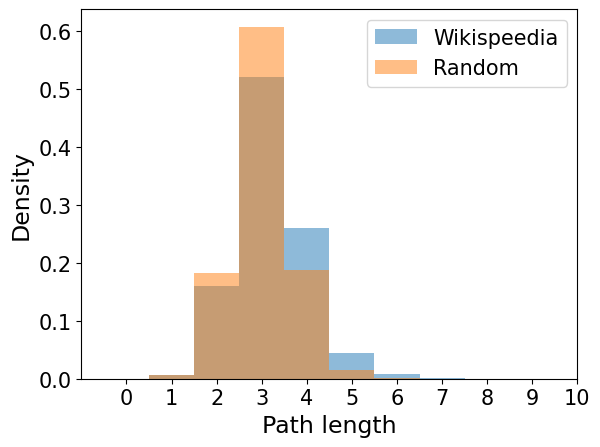

In [96]:
_ = plt.hist(lengths_list_G, bins=range(max_len + 1), density='True', align='left', alpha=0.5, label='Wikispeedia')
_ = plt.hist(range(max_len + 1), weights=hists_mean, bins=range(max_len + 1), align='left', alpha=0.5, label='Random')
_ = plt.xticks(range(max_len + 1))
_ = plt.xlabel('Path length')
_ = plt.ylabel('Density')
_ = plt.legend()

_ = plt.savefig('WikispeediaVSRandom.pdf')

# Random Walks

Analysis on the maximum, minimum and average length of the users' paths

Min length: 1
Max length: 410
Average length: 6.052983358665576
Total number of paths:  51318
Number of paths with length over 30: 54


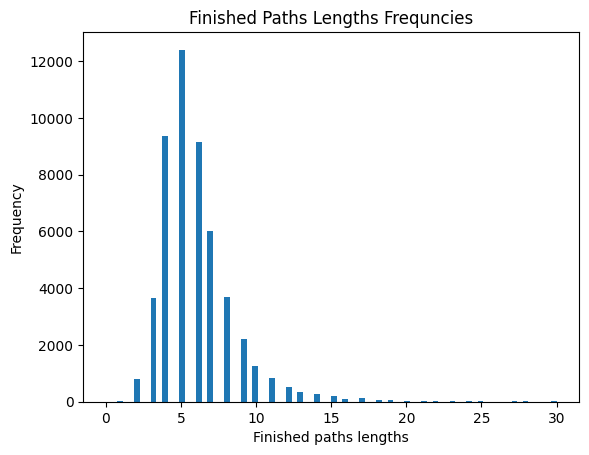

In [ ]:
#store all path lengths
p_fin_lengths = []
sum_length = 0
for f_path in paths_finished:
    l = len(f_path)
    p_fin_lengths.append(l)
    sum_length += l

#calculate min, max, average lengths
print("Min length:", min(p_fin_lengths))
print("Max length:", max(p_fin_lengths))
print("Average length:", sum_length / len(p_fin_lengths))

#count the number of paths with length over 30
count_over_30 = len([i for i in p_fin_lengths if i > 30])
print("Total number of paths: ", len(p_fin_lengths))
print("Number of paths with length over 30:", count_over_30)

#plot the histogram of the path lengths frewuencies
plt.hist(p_fin_lengths, bins = 80, range = (0, 30))
plt.xlabel('Finished paths lengths')
plt.ylabel('Frequency')
plt.title('Finished Paths Lengths Frequncies')
plt.show()



Method to perform a random walk of at most n steps

In [ ]:
def do_random_walk(g, source, destination, n):
  crossed_nodes = []
  current_node = source
  crossed_nodes.append(current_node)
  for i in range(n):
    if current_node == destination:
      break
    list_neighbors = list(g.neighbors(current_node))
    if len(list_neighbors)==0:
      break
    else:
      current_node = random.choice(list_neighbors)
      crossed_nodes.append(current_node)
  return crossed_nodes

Plot the lengths of the users paths and the lengths of the random walks

In [ ]:
def plot_user_random_paths_lengths(user_lengths, random_lengths, paths_count):
    plt.figure(figsize=(15, 8))

    offset = 0.15 

    plt.bar(range(paths_count), user_lengths, width=0.1, color='blue', label="User Path")

    for i in range(paths_count):
        for j, length in enumerate(random_lengths[i]):
            if j > 1/offset - 1: 
                break
            plt.bar(
                i + (j + 1) * offset, 
                length,
                width=0.1,
                color='orange',
                label="Random Path" if i == 0 and j == 0 else ""
            )

    plt.title("User and Random paths lengths", fontsize=16)
    plt.xlabel("Attempts", fontsize=14)
    plt.ylabel("Path Length", fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(axis='y', linestyle='--')

    plt.show()

Perform some random walks on a subset of source and destination nodes picked from the user's finished paths. Compare the paths lengths.

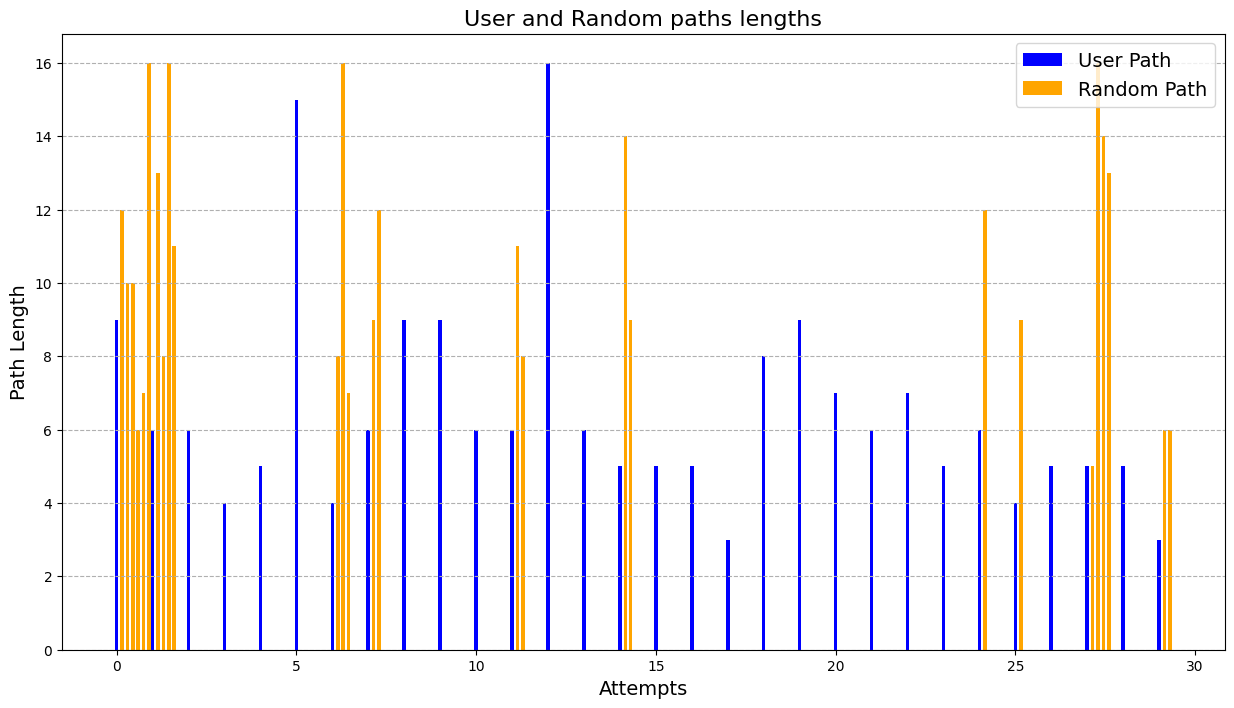

In [ ]:
number_of_finished_paths = 30
number_of_random_attempts = 200
max_steps = 15

user_lengths = [] 
random_lengths = [[] for _ in range(number_of_finished_paths)]  

for i in range(number_of_finished_paths):
    random_i = random.choice(range(len(paths_finished)))
    source, destination = paths_finished[random_i][0], paths_finished[random_i][-1]

    #print("-", source, "-->", destination)
    
    user_lengths.append(len(paths_finished[random_i]))
    
    for j in range(number_of_random_attempts):
        crossed_nodes = do_random_walk(G, source, destination, max_steps)
        if crossed_nodes[-1] == destination:
            random_lengths[i].append(len(crossed_nodes)) 
            #print("Number of steps:", len(crossed_nodes), " --> ", crossed_nodes)
    #if len(random_lengths[i]) == 0:
        #print("No path found")

plot_user_random_paths_lengths(user_lengths, random_lengths, number_of_finished_paths)

Random paths for the game which users needed more than 30 steps. Compare the paths lengths.

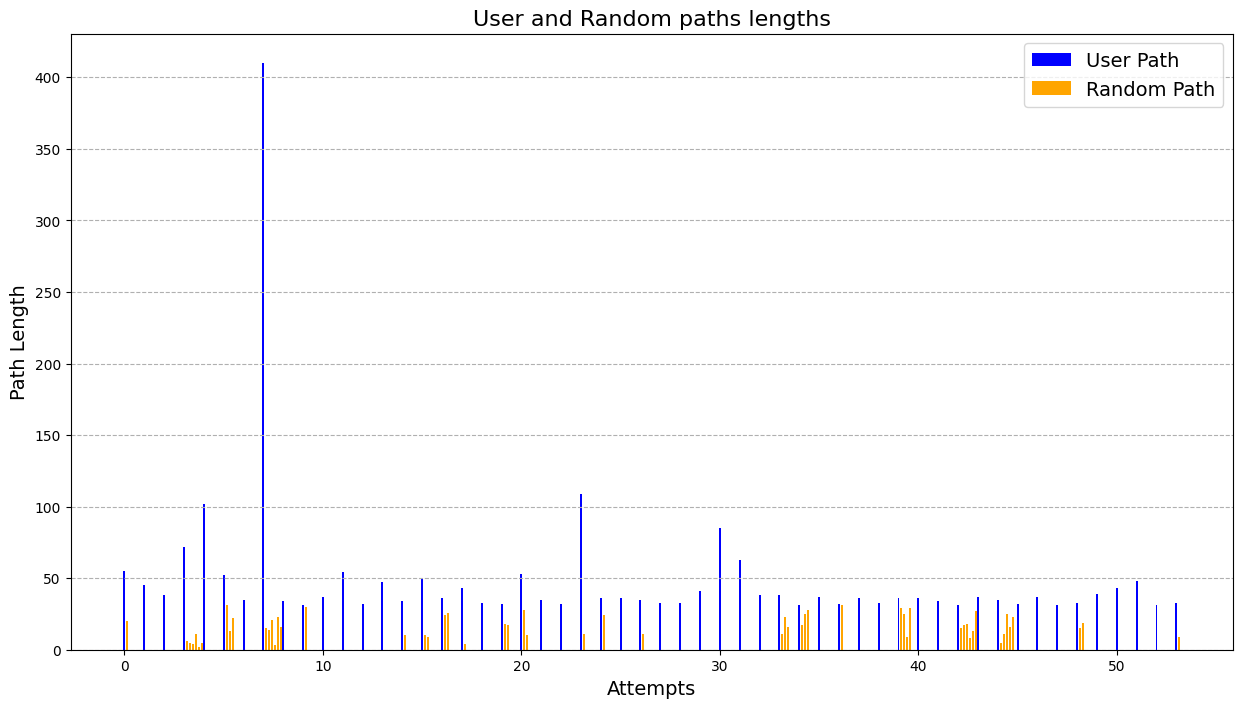

In [ ]:
number_of_finished_paths = 30
number_of_random_attempts = 200
max_steps = 30

user_lengths = [] 
random_lengths = [[] for _ in range(count_over_30)]  

i = 0
for path in paths_finished:
    if(len(path) <= 30):
        continue
    
    source, destination = path[0], path[-1]
    
    user_lengths.append(len(path))
    
    for j in range(number_of_random_attempts):
        crossed_nodes = do_random_walk(G, source, destination, max_steps)
        if crossed_nodes[-1] == destination:
            random_lengths[i].append(len(crossed_nodes)) 
    i += 1

plot_user_random_paths_lengths(user_lengths, random_lengths, count_over_30)

Perform some random walks on a subset of source and destination nodes picked from the user's finished paths. Compare the paths lengths.

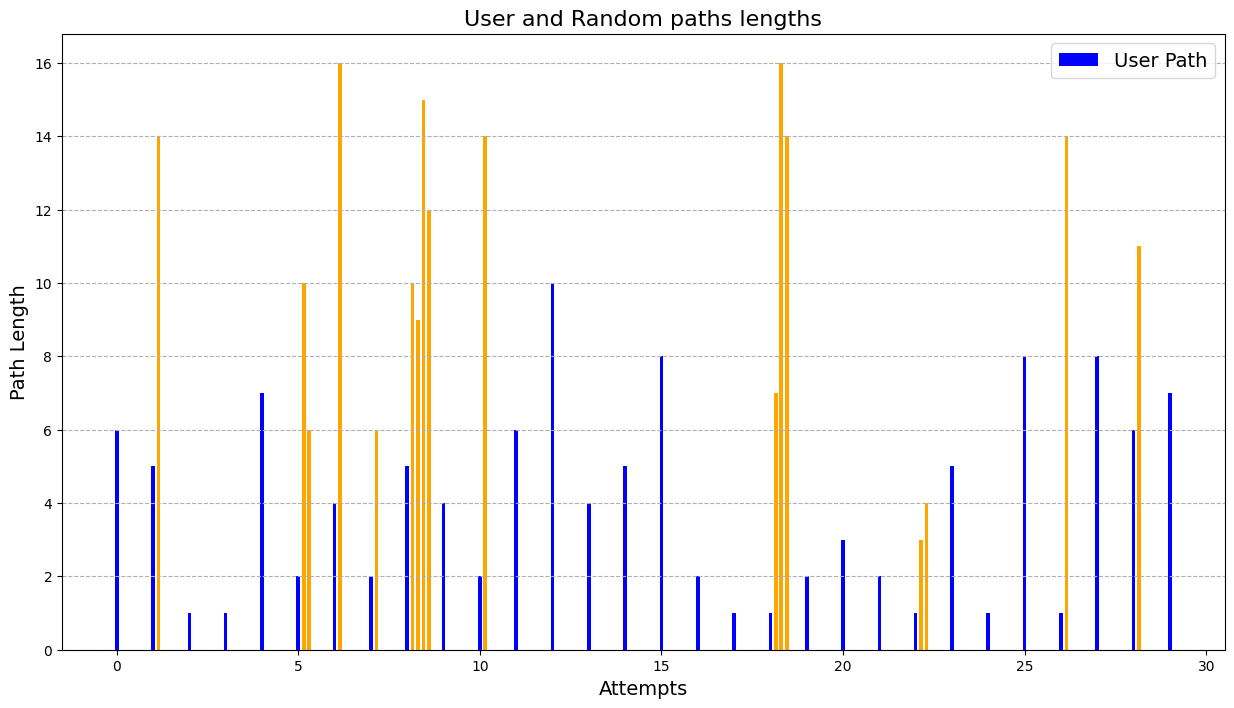

In [ ]:
number_of_finished_paths = 30
number_of_random_attempts = 200
max_steps = 15

user_lengths = [] 
random_lengths = [[] for _ in range(number_of_finished_paths)]  

for i in range(number_of_finished_paths):
    random_i = random.choice(range(len(paths_unfinished)))
    source, destination = paths_unfinished['path'][random_i][0], paths_unfinished['target'][random_i]

    #print("-", source, "-->", destination)
    
    user_lengths.append(len(paths_unfinished['path'][random_i]))
    
    for j in range(number_of_random_attempts):
        crossed_nodes = do_random_walk(G, source, destination, max_steps)
        if crossed_nodes[-1] == destination:
            random_lengths[i].append(len(crossed_nodes)) 
            #print("Number of steps:", len(crossed_nodes), " --> ", crossed_nodes)
    #if len(random_lengths[i]) == 0:
        #print("No path found")

plot_user_random_paths_lengths(user_lengths, random_lengths, number_of_finished_paths)

Computation ...

In [ ]:
number_of_random_attempts = 200
max_steps = 20

user_lengths = [] 
random_lengths = [[] for _ in range(len(paths_finished))]  

for i in range(len(paths_finished)):
    source, destination = paths_finished[i][0], paths_finished[i][-1]

    user_lengths.append(len(paths_finished[i]))
    
    for j in range(number_of_random_attempts):
        crossed_nodes = do_random_walk(G, source, destination, max_steps)
        if crossed_nodes[-1] == destination:
            random_lengths[i].append(len(crossed_nodes)) 

num_unfinished_random_paths = len([i for i in random_lengths if len(i) == 0])
print("Number of games without a finished random path: ", num_unfinished_random_paths)
print("Total number of paths: ", len(paths_finished))

Number of games without a finished random path:  30163
Total number of paths:  51318


Computation ...

In [ ]:
number_of_random_attempts = 200
max_steps = 15

user_lengths = [] 
random_lengths = [[] for _ in range(len(paths_unfinished))]  

for i in range(len(paths_unfinished)):
    source, destination = paths_unfinished['path'][i][0], paths_unfinished['target'][i]
    
    user_lengths.append(len(paths_unfinished['path'][i]))
    
    for j in range(number_of_random_attempts):
        crossed_nodes = do_random_walk(G, source, destination, max_steps)
        if crossed_nodes[-1] == destination:
            random_lengths[i].append(len(crossed_nodes)) 

: 

# Clustering

## Performing Greedy Clustering
### Execution time: 3 min

In [ ]:
greedy_clustering = nx.algorithms.community.greedy_modularity_communities(G)

In [ ]:
for i, clust in enumerate(greedy_clustering):
    print(f"Cluster {i+1}: {sorted(clust)} \n\n\n")

Cluster 1: ['16_Cygni', '16_Cygni_Bb', '1980_eruption_of_Mount_St._Helens', '1_Ceres', '3_Juno', '47_Ursae_Majoris', '47_Ursae_Majoris_b', '47_Ursae_Majoris_c', '4_Vesta', '55_Cancri', '55_Cancri_b', '55_Cancri_c', '55_Cancri_d', '55_Cancri_e', '90377_Sedna', 'ABO_blood_group_system', 'ATLAS_experiment', 'Aardvark', 'Abac%C3%A1', 'Abacus', 'Abadan', 'Aberration_of_light', 'Absinthe', 'Absolute_zero', 'Acceleration', 'Acetic_acid', 'Acetone', 'Achilles', 'Achilles_tendon', 'Acid_rain', 'Actinium', 'Action_potential', 'Adam_Smith', 'Adenosine_triphosphate', 'Aesthetics', 'Afghan_Hound', 'African_Black_Oystercatcher', 'African_Brush-tailed_Porcupine', 'African_Darter', 'African_Grey_Hornbill', 'African_Grey_Parrot', 'African_Jacana', 'African_Penguin', 'African_Wild_Dog', 'African_clawed_frog', 'African_dwarf_frog', 'Agamemnon', 'Age_of_Enlightenment', 'Agnosticism', 'Aircraft', 'Alamosaurus', 'Alan_Turing', 'Albatross', 'Albert_Einstein', 'Albertosaurus', 'Albinism', 'Albrecht_D%C3%BCrer

## Performing Louvian Clustering

In [ ]:
louv_clustering = nx.algorithms.community.louvain_communities(G, seed = 587)
louv_clustering = sorted(louv_clustering, key=len, reverse=True)

In [ ]:
for i, clust in enumerate(louv_clustering):
    print(f"Cluster {i+1}: {sorted(clust)} \n\n\n")

Cluster 1: ['ABO_blood_group_system', 'Aardvark', 'Abac%C3%A1', 'Absinthe', 'Action_potential', 'Afghan_Hound', 'African_Black_Oystercatcher', 'African_Brush-tailed_Porcupine', 'African_Darter', 'African_Grey_Hornbill', 'African_Grey_Parrot', 'African_Jacana', 'African_Penguin', 'African_Wild_Dog', 'African_clawed_frog', 'African_dwarf_frog', 'Agriculture', 'Alamosaurus', 'Albatross', 'Albertosaurus', 'Albinism', 'Alligator', 'Allosaurus', 'Almond', 'Alternation_of_generations', 'Alzheimer%27s_disease', 'Amaranth_oil', 'Amazon_parrot', 'Ammonite', 'Ammosaurus', 'Anaconda', 'Anatomy', 'Anemia', 'Angel_shark', 'Angelica', 'Animal', 'Ankylosaurus', 'Ant', 'Antarctic_krill', 'Antarctica', 'Antarctosaurus', 'Anteater', 'Antelope', 'Antlion', 'Apatosaurus', 'Ape', 'Aphid', 'Apple', 'Apricot', 'Aquarium', 'Archaeopteryx', 'Arctic', 'Arctic_Circle', 'Arctic_Ocean', 'Arctic_Tern', 'Argan', 'Armadillo', 'Arp2_3_complex', 'Arthropod', 'Arugula', 'Ascariasis', 'Asia', 'Asparagus', 'Asthma', 'Atlan

## Connected components

In [ ]:
connected_components = nx.weakly_connected_components(G)
for i, component in enumerate(connected_components):
    print(f"Component {i+1}: {component} \n\n\n")

Component 1: {'Iraq_War', 'Wyndham_Robertson', 'Romania', 'Loch', 'Henry_Wood_%28conductor%29', 'Salt', 'Tony_Blair', 'Stratford-upon-Avon', 'Day', 'Electron_beam_welding', 'Paul_C%C3%A9zanne', 'Yuri_Gagarin', 'Coffee', 'Nanomedicine', 'Pacific_Ocean', 'List_of_European_countries', 'Warsaw', 'Stegosaurus', 'Bodyline', 'Planetary_habitability', 'Ancient_Rome', 'Christopher_Wren', 'Monarchy', 'Actor', 'Nouakchott', 'Carl_G._Fisher', 'Forensic_facial_reconstruction', 'Polish-Soviet_War', 'Rosemary', 'Tsunami', 'Akira_Kurosawa', 'Tamil_people', 'History_of_painting', 'Cologne', 'Button', 'Zachary_Taylor', 'Ankylosaurus', 'HSBC', 'Moorgate', 'Kyrgyzstan', 'Hafnium', 'Sodium', 'Battles_of_the_Mexican-American_War', 'FIFA', 'Gorilla', 'Oil_painting', 'Afrikaans', 'Rupee', 'Sand_shark', 'Aircraft_carrier', 'Alligator', 'Nightingale', 'Mediterranean_Sea', 'Denis_Law', 'Jamaica', 'Auckland', 'Puerto_Rico', 'Cod', 'Felice_Beato', 'Thomas_Pynchon', 'Diamond_simulant', 'Stanis%C5%82aw_Koniecpolski'

## Categories

In [ ]:
article_categ = pd.read_csv('wikispeedia_paths-and-graph/categories.tsv', delimiter='\t', names=['articles','categories'], header=None, comment="#")
article_categ['categories'] = article_categ['categories'].str.split('.').str.get(1)  #to get only the first category after "subject"
categories_set = set(article_categ['categories'])
categories_set.add("NOTAG")
print(categories_set)

{'Music', 'Religion', 'Everyday_life', 'Design_and_Technology', 'Mathematics', 'People', 'Science', 'IT', 'NOTAG', 'Geography', 'History', 'Business_Studies', 'Language_and_literature', 'Art', 'Citizenship', 'Countries'}


In [ ]:
article_categ.to_csv('couple_art_cat.tsv', sep='\t', index=False, header=True)
no_tag_articles = articles[~articles['article'].isin(article_categ['articles'])]['article'].tolist() #to get the articles that have no category
print(no_tag_articles)

for art in no_tag_articles:                                                                         #adding them in the article_categ dataframe
    new_row = pd.DataFrame({'articles': art, 'categories': ["NOTAG"]})
    article_categ = pd.concat([article_categ, new_row], ignore_index=True)

['Directdebit', 'Donation', 'Friend_Directdebit', 'Pikachu', 'Sponsorship_Directdebit', 'Wowpurchase']


In [ ]:
art_cat_sets = article_categ.groupby('articles', as_index=False)['categories'].apply(lambda x: set(x)) #to remove duplicates
art_cat_sets.to_csv('Sets_Art_Cat.tsv', sep='\t', index=False, header=True)

## Articles with multiple categories

In [ ]:
max_cardinality = art_cat_sets['categories'].apply(len).max()

for i in range(1,max_cardinality+1):
    articles_with_i_cat = art_cat_sets[art_cat_sets['categories'].apply(len) == i]

    print("There are "+str(len(articles_with_i_cat))+" articles with cardinality "+str(i) + " :")
    if(i==max_cardinality):
        print(articles_with_i_cat)

There are 4098 articles with cardinality 1 :
There are 505 articles with cardinality 2 :
There are 1 articles with cardinality 3 :
     articles                              categories
3332  Pottery  {Business_Studies, Art, Everyday_life}


## Categories of the clusters

In [ ]:
def dict_categories_list(G, clustering, art_cat_sets, toPrint = False):

    dict_cat_list = {i: {key: [] for key in categories_set } for i in range(len(clustering))}
    for i, clust in enumerate(clustering):
        for article in list(G.nodes):
            if article in clust:
                if article in art_cat_sets['articles'].values:
                    for categ in art_cat_sets.loc[art_cat_sets['articles'] == article, 'categories'].values[0]:
                        dict_cat_list[i][categ].append(article)
    if toPrint:
        for clust in dict_cat_list:
            print("Cluster " +str(clust+1)+":")
            for key in dict_cat_list[clust]:
                if dict_cat_list[clust][key]:
                    print(str(key)+"\t" +str(dict_cat_list[clust][key]))
                    print("\n")
            print("\n ################################################################################################################################################################################################## \n")
    
    return dict_cat_list
                        

In [ ]:
greedy_dict = dict_categories_list(G, greedy_clustering, art_cat_sets, True)

Cluster 1:
Music	['Music', 'White_Mountain_art']


Religion	['Zeus', 'Philosophy', 'Heliocentrism', 'Religion', 'Roman_mythology', 'Existentialism', 'Greek_mythology', 'Empiricism', 'Apollo', 'Athena', 'Ethics', 'Logic', 'Utilitarianism', 'Brahman', 'Deity', 'Age_of_Enlightenment', 'Agnosticism', 'Atheism', 'God', 'Mysticism', 'Stoicism', 'Jupiter_%28mythology%29', 'Folklore', 'Mind', 'Humanism', 'Celtic_mythology', 'Norse_mythology', 'Deluge_%28mythology%29', 'Creationism', 'Quetzalcoatl', 'Philosophy_of_mind', 'Vampire', 'Spring_Heeled_Jack', 'Creation-evolution_controversy', 'Flat_Earth', 'Capitoline_Triad', 'Scottish_mythology', 'Maya_mythology', 'Comma_Johanneum', 'Thor', 'Odin', 'I_Ching', 'Dualism_%28philosophy_of_mind%29', 'Eliminative_materialism', 'Kohlberg%27s_stages_of_moral_development', 'Shroud_of_Turin']


Everyday_life	['Absinthe', 'Beer', 'Photography', 'Cereal', 'Abacus', 'Day', 'Season', 'Science', 'Apple', 'Emotion', 'Potato', 'Citrus', 'Vegetable', 'Fashion', 'Toba

In [ ]:
louv_dict = dict_categories_list(G, louv_clustering, art_cat_sets, True)

Cluster 1:
Music	['Italo_disco']


Religion	['Norse_mythology', 'Vampire', 'Creation-evolution_controversy']


Everyday_life	['Absinthe', 'Beer', 'Cereal', 'Rice', 'Wheat', 'Season', 'Tea', 'Apple', 'Potato', 'Banana', 'Agriculture', 'Citrus', 'Vegetable', 'Tobacco_smoking', 'Vitamin', 'Jaws_%28film%29', 'King_Kong_%282005_film%29', 'Fruit', 'Pig', 'Cattle', 'Garden', 'Coriander', 'Distilled_beverage', 'Fennel', 'Nutmeg', 'Star_anise', 'Sugar', 'Food', 'Yeast', 'Domestic_goat', 'Barley', 'Beekeeping', 'Egg_%28food%29', 'Honey', 'Meat', 'Milk', 'Pea', 'Soybean', 'Pond', 'Spring_%28season%29', 'Calvin_and_Hobbes', 'Almond', 'Fatty_acid', 'Olive_oil', 'Plum', 'Vitamin_C', 'Summer', 'Fishing', 'Celery', 'Chicken', 'Bread', 'Cheese', 'Onion', 'Apricot', 'Parsley', 'Aquarium', 'Black_pepper', 'Cultivar', 'Halloween', 'Coconut', 'Sugarcane', 'Arugula', 'Basil', 'Lettuce', 'Asparagus', 'Sleep', 'Harvest', 'Avocado', 'Lemon', 'Thiamine', 'Vitamin_D', 'Bran', 'Bean', 'Peanut', 'Beet', 'Carrot', 

In [ ]:
def dict_categ_cardinality_per_cluster(alg_dict, toPrint = False):
    perc_dict = {clust: {categ: len(alg_dict[clust][categ]) for categ in alg_dict[0] } for clust in range(len(alg_dict))}
    
    for clust in alg_dict:
        print("Clustering :" + str(clust+1))
        for categ in alg_dict[clust]:
            if toPrint:
                print(str(str(categ)+":\t\t\t"+"{:d}".format(perc_dict[clust][categ])).rjust(40))
    return perc_dict

In [ ]:
greedy_card_dict = dict_categ_cardinality_per_cluster(greedy_dict,True)

Clustering :1
                              Music:			2
                          Religion:			46
                    Everyday_life:			126
             Design_and_Technology:			52
                       Mathematics:			44
                           People:			117
                         Science:			1019
                                IT:			16
                              NOTAG:			0
                        Geography:			198
                           History:			53
                  Business_Studies:			18
           Language_and_literature:			18
                               Art:			15
                       Citizenship:			52
                          Countries:			2
Clustering :2
                             Music:			14
                          Religion:			58
                     Everyday_life:			68
             Design_and_Technology:			50
                        Mathematics:			0
                           People:			184
                           Science:			43
                             

In [ ]:
louv_card_dict = dict_categ_cardinality_per_cluster(louv_dict,True)

Clustering :1
                              Music:			1
                           Religion:			3
                    Everyday_life:			112
              Design_and_Technology:			3
                        Mathematics:			0
                            People:			17
                          Science:			633
                                 IT:			1
                              NOTAG:			0
                         Geography:			81
                            History:			7
                   Business_Studies:			1
            Language_and_literature:			1
                                Art:			1
                        Citizenship:			8
                          Countries:			5
Clustering :2
                             Music:			67
                           Religion:			4
                     Everyday_life:			98
             Design_and_Technology:			89
                        Mathematics:			1
                           People:			160
                           Science:			34
                             

## Plotting the results

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as cm
from matplotlib import colormaps

def show_partial_plot_clustering(card_dict,plot_title,start_pos,end_pos,fig_len, big_val):

    data_dicts =  list(card_dict.values())[start_pos:end_pos + 1]
    data_dicts
    # Number of dictionaries
    k = len(data_dicts)
    categories = list(data_dicts[0].keys())
    x_positions = np.arange(k)  # Positions for bar groups
        
    num_categories = len(categories)
    #cmap = cm.get_cmap('tab20c_r',num_categories)  # You can choose other colormaps like 'viridis', 'plasma', etc.
    #colors = [cmap(i / num_categories) for i in range(num_categories)]
    # Initialize figure
    fig, ax = plt.subplots(figsize=(fig_len,5))
    colors = plt.cm.tab20(np.linspace(0,1,num_categories))

    # Initialize the bottom tracker for each bar group
    bottom_values = [0] * k  

    # Plot stacked bars for each category
    

    for i, category in enumerate(categories):
        heights = [data[category] for data in data_dicts]
        ax.bar(x_positions, heights, bottom=bottom_values, label=category, color = colors[i])
        # Update the bottom tracker
        bottom_values = [bottom + height for bottom, height in zip(bottom_values, heights)]

    # Customization
    ax.set_xticks(x_positions)
    ax.set_xticklabels([f"{i+start_pos+1}" for i in range(k)])
    if(big_val):
        ax.set_ylim(0, 2000)
    else:
        ax.set_ylim(0, 60)
    ax.set_title(plot_title)
    ax.set_xlabel("Clusters")
    ax.set_ylabel("Cumulative categories cardinality")
    ax.legend(title="Categories", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adjust layout and show the plot
    plt.tight_layout()
    #plt.savefig('images/clustering/'+plot_title+'.pdf', dpi=300, bbox_inches='tight')
    plt.show()
   


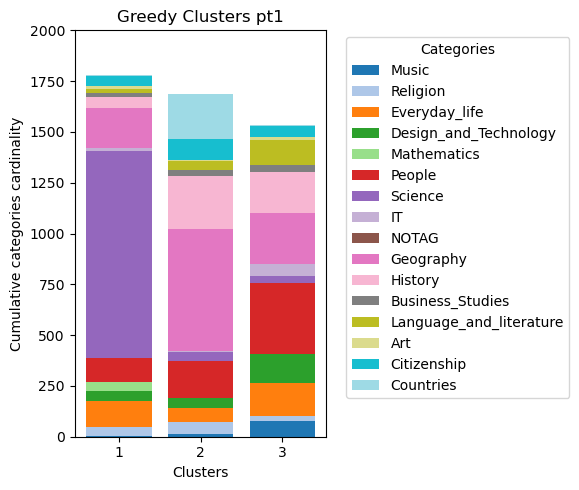

In [ ]:
show_partial_plot_clustering(greedy_card_dict,"Greedy Clusters pt1",0,2,6,True)

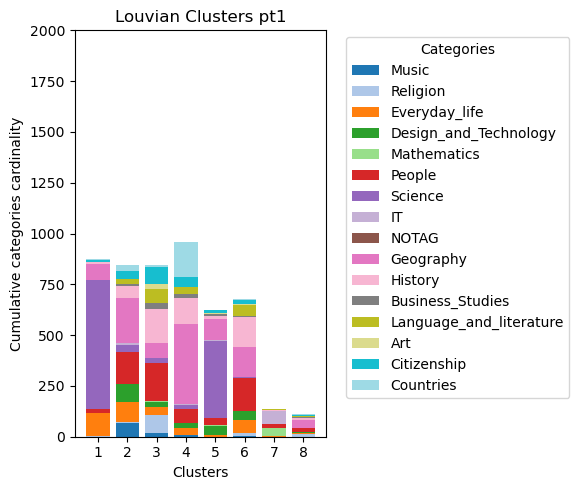

In [ ]:
show_partial_plot_clustering(louv_card_dict,"Louvian Clusters pt1",0,7,6,True)

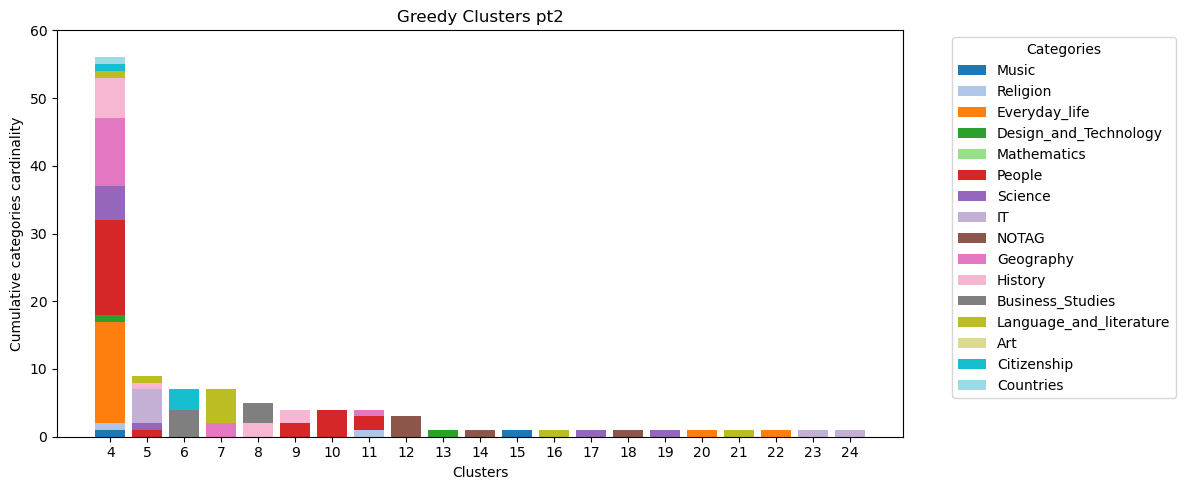

In [ ]:
show_partial_plot_clustering(greedy_card_dict,"Greedy Clusters pt2",3,len(greedy_card_dict),12,False)

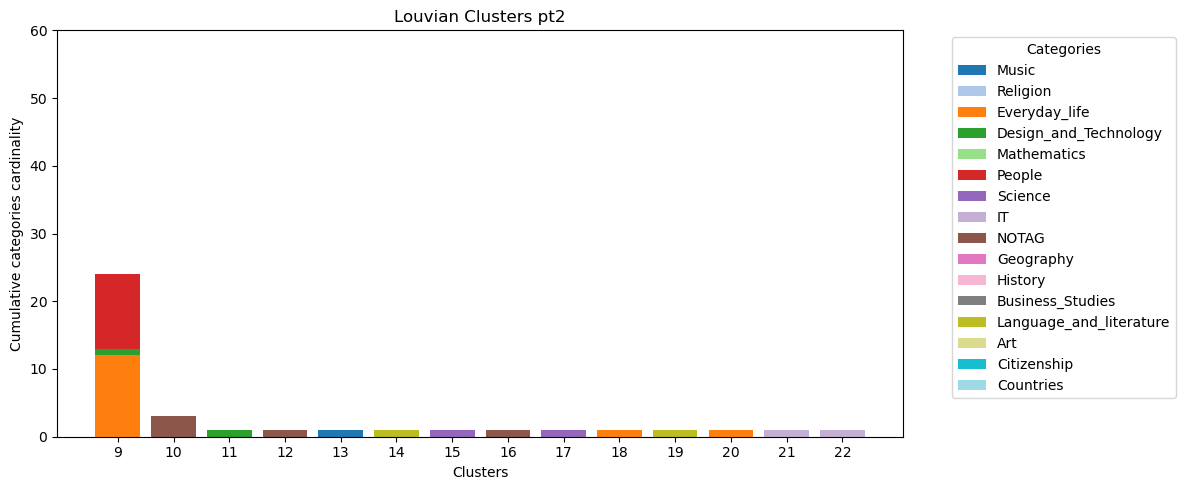

In [ ]:
show_partial_plot_clustering(louv_card_dict,"Louvian Clusters pt2",8,len(louv_card_dict),12,False)